In [6]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

In [7]:
model_name = 'ORD2011'
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact =False

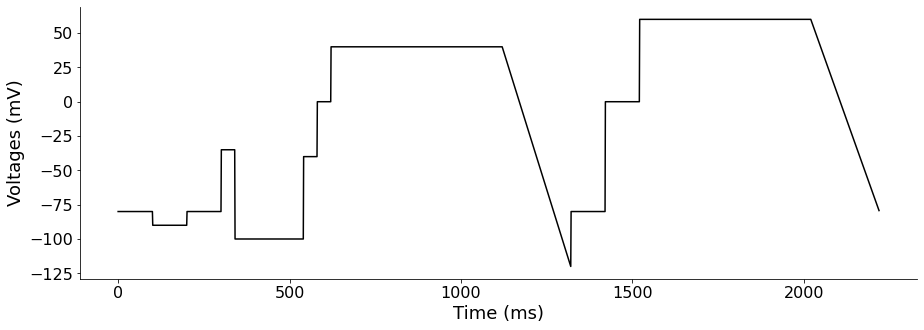

In [8]:
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-100, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 1) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [22]:
import simulator_myokit
import myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ohara-cipa-v1-2017_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, VC_protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=-80) # 1e-12, 1e-14 # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.0001
sim_myokit.name = "OHara2017-CiPA-v1"

In [23]:
start_time = time.time()

sim_myokit.simulation.set_constant('cell.mode', 1)    
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate( VC_protocol.get_voltage_change_endpoints()[-1], log_times=None, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1'] )

print("--- %s seconds ---"%(time.time()-start_time))
d_myokit

--- 0.13393545150756836 seconds ---


inf

In [4]:
start_time = time.time()

currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(VC_protocol)
    tr = model_response.get_model_response_JK(model, VC_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, VC_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(VC_protocol)  
    tr = model_response.get_model_response_JK(model, VC_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=True)        
    tr = k.generate_response(VC_protocol, is_no_ion_selective=False)

print("--- %s seconds ---"%(time.time()-start_time))

D:\Asan\Codes\Electrophysiology\Optimize_protocol\../Models\ord2011.py:399: RuntimeWarning: invalid value encountered in double_scalars
  PhiCaL  = 4 * vffrt *(       cass  * exp(2 * vfrt) - 0.341 * self.extra.Cao) / (exp(2 * vfrt) - 1)
D:\Asan\Codes\Electrophysiology\Optimize_protocol\../Models\ord2011.py:400: RuntimeWarning: invalid value encountered in double_scalars
  PhiCaNa = 1 * vffrt *(0.75 * Na_ss   * exp(1 * vfrt) - 0.75  * self.extra.Nao) / (exp(1 * vfrt) - 1)
D:\Asan\Codes\Electrophysiology\Optimize_protocol\../Models\ord2011.py:401: RuntimeWarning: invalid value encountered in double_scalars
  PhiCaK  = 1 * vffrt *(0.75 * K_ss * exp(1 * vfrt) - 0.75  * self.extra.Ko ) / (exp(1 * vfrt) - 1)
D:\Asan\Codes\Electrophysiology\Optimize_protocol\../Models\ord2011.py:762: RuntimeWarning: invalid value encountered in double_scalars
  INab = (A*U)/(exp(U)-1.0)
D:\Asan\Codes\Electrophysiology\Optimize_protocol\../Models\ord2011.py:783: RuntimeWarning: invalid value encountered in dou

ValueError: array must not contain infs or NaNs

In [ ]:
start_time = time.time()
current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
total_current = tr.current_response_info.get_current_summed()
c_li = {}
for current_name in currents:
    c = []
    for t in tr.t:    
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        c.append(current_contributions[current_name].loc[idx])        
    c_li[current_name] = c
print("--- %s seconds ---"%(time.time()-start_time))

In [ ]:
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)
max_contributions

In [ ]:
'''
Plot
'''
fig, ax = plt.subplots(9,1, figsize=(15,25))    
fig.suptitle(model_name, fontsize=14)
total_duration = holding_step
for i, name in enumerate(['Voltage', 'I_total'] + currents):        
#     ax[i].set_title(name)
    # ax[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax[i].set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)', fontsize=14)           
    ax[i].tick_params(axis="x", labelsize=14)
    ax[i].tick_params(axis="y", labelsize=14)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)     
    ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))    
    if i==0:
        ax[i].set_ylabel(f'{name} (mV)', fontsize=14)     
        ax[i].plot( tr.t, VC_protocol.get_voltage_clamp_protocol(tr.t), label=name, color='k')    
    elif i==1:
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14)     
        ax[i].plot( tr.t, tr.current_response_info.get_current_summed(), label=name, color='k', linewidth=2)
    else:         
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14) 
        ax_im = ax[i].scatter(tr.t, tr.current_response_info.get_current([name]), c=c_li[name], cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
        
        contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
        start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
        end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.4)   
#         ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))    

#     ax[i].legend(loc=2, prop={'size': 14})    
    ax[i].grid()
# fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig( f"aaa.jpg", dpi=200)
plt.close(fig)

In [ ]:
# for current_name in currents:
#     tr.plot_currents_contribution(current_name,  window=window, step_size=step_size, is_shown=True, title=current_name,
#                                   saved_to=f'./ga_results/{trial_conditions}/{current_name}.svg')

In [ ]:
# print("Complete")